------ Deflections for [0/90] ------
a/h  | FSDT (sin) | CPT (sin) | FSDT (uni) | CPT (uni)
------------------------------------------
2    |     5.4059 |    1.0636 |     8.7637 |    1.7242
5    |     1.7584 |    1.0636 |     2.8505 |    1.7242
10   |     1.2373 |    1.0636 |     2.0058 |    1.7242
20   |     1.1070 |    1.0636 |     1.7946 |    1.7242
100  |     1.0653 |    1.0636 |     1.7270 |    1.7242

------ Deflections for [0/90]^3 ------
a/h  | FSDT (sin) | CPT (sin) | FSDT (uni) | CPT (uni)
------------------------------------------
4    |     1.5473 |    0.4617 |     2.5084 |    0.7486
10   |     0.6354 |    0.4617 |     1.0301 |    0.7486
20   |     0.5052 |    0.4617 |     0.8190 |    0.7486
50   |     0.4687 |    0.4617 |     0.7598 |    0.7486
100  |     0.4635 |    0.4617 |     0.7514 |    0.7486


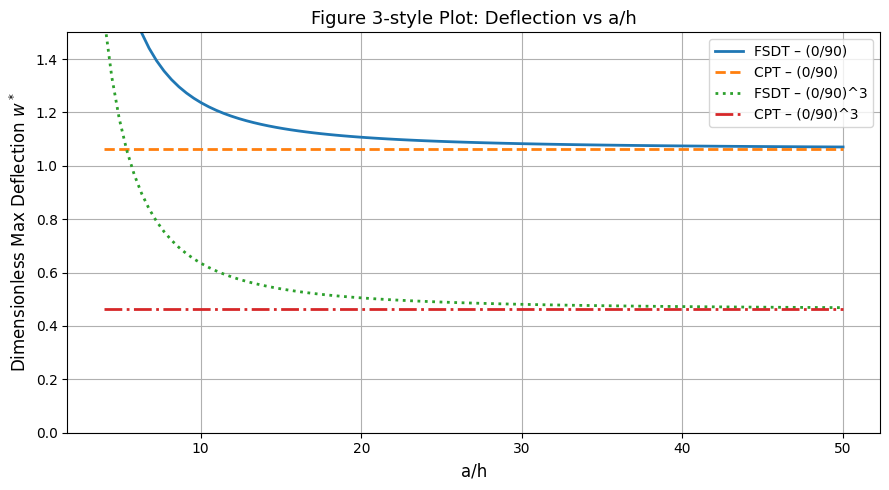

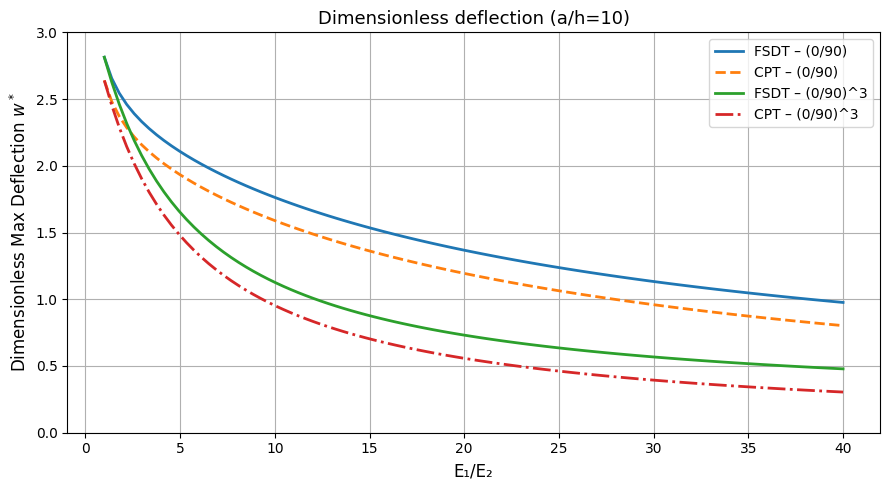

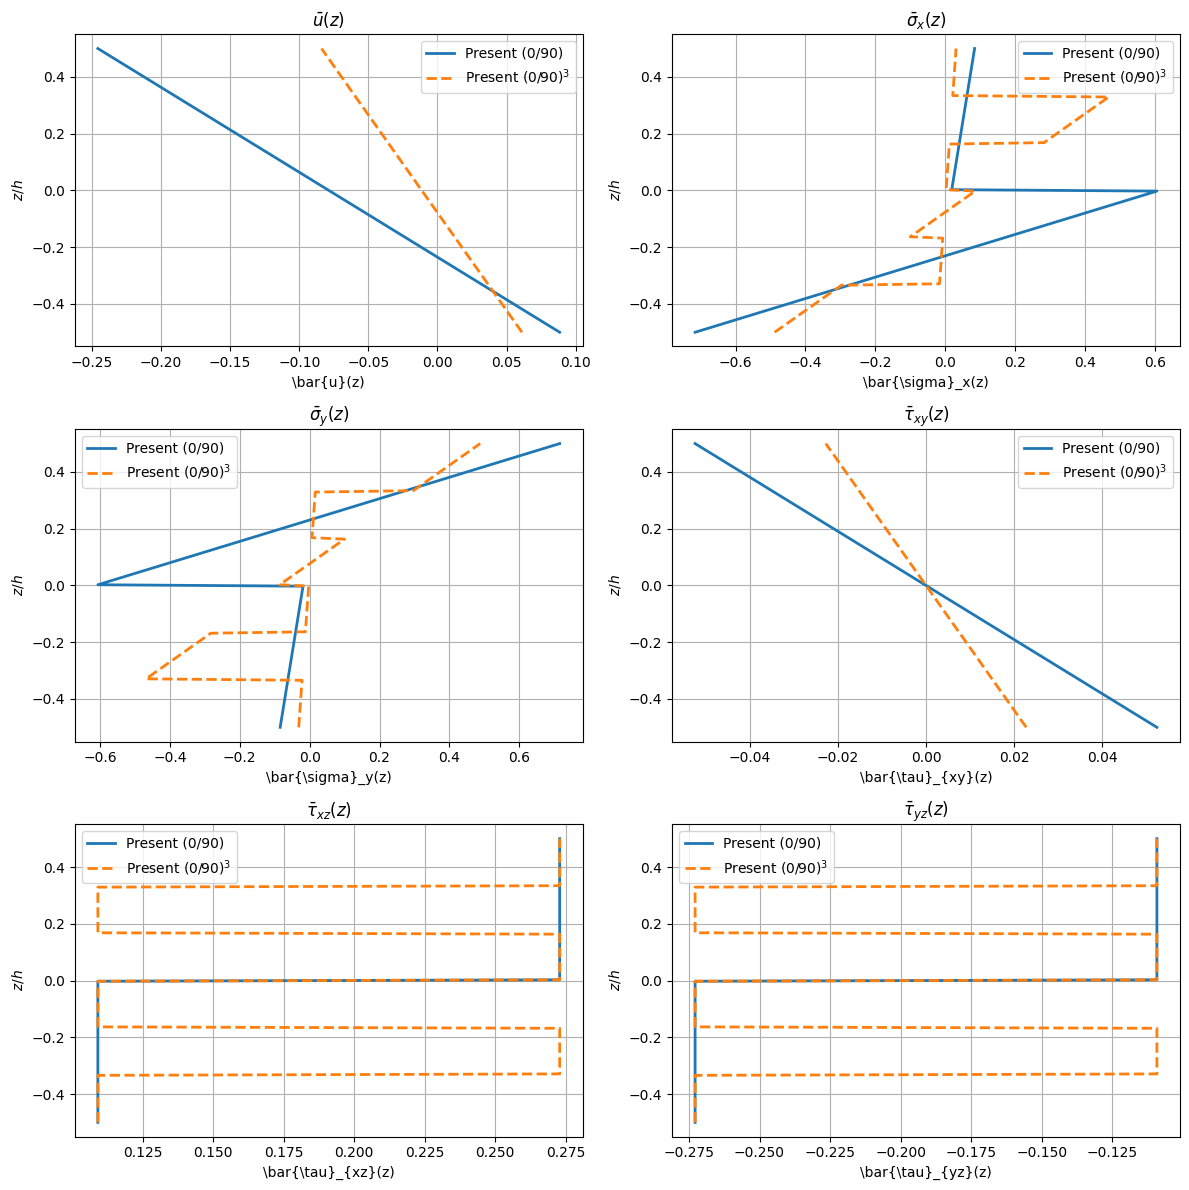

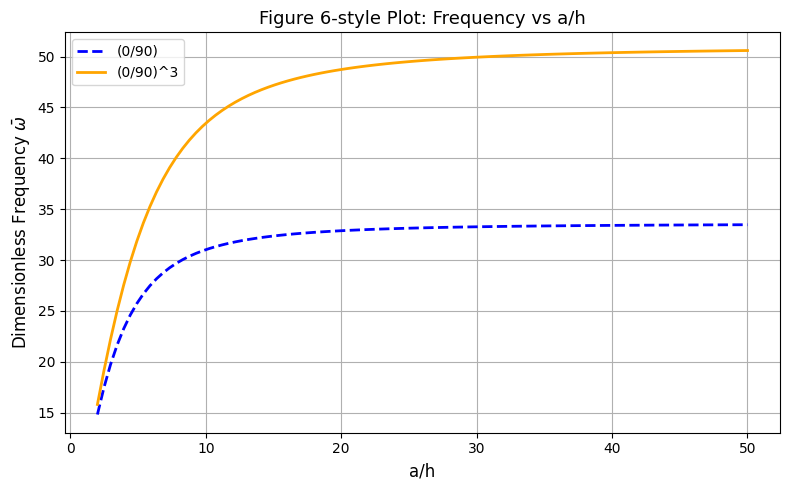

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import eig
import math


# Introduction:
# This code uses First-Order Shear Deformation Theory (FSDT) and Classical Plate Theory (CPT) to calculate deflection, stress, and vibration of a composite beam.
# Developed for the Composite Structure course (Instructor: Sardar Malek, University of Victoria) by MJ Sharifi.
# Referenced equations are available in the accompanying report, Reddy's book, and Ref. [1] by Huu-Tai Thai.
# Notes:
# - Fully validated for deflection and stress.
# - Vibration results use analytical stiffness/mass matrices but still need final validation.
# - Code uses dimensionless forms. Rescale as needed for real applications.


# ----------------------------------------------------
# 1) Material 1 properties (scaled so E2=1)
# ----------------------------------------------------
E2 = 1.0
E1 = 25.0 * E2
nu12 = 0.25
nu21 = nu12 * (E2 / E1)
G12 = 0.5 * E2
G13 = 0.5 * E2
G23 = 0.2 * E2
h = 1.0
j = 5.0 / 6.0
q0 = 1.0
a = 10.0
b = 10.0
alpha = math.pi / a
beta = math.pi / b

# ----------------------------------------------------
# 2) Local Q matrix
# ----------------------------------------------------
def Q_local():
    denom = 1.0 - nu12 * nu21
    Q11 = E1 / denom
    Q12 = nu12 * E2 / denom
    Q22 = E2 / denom
    Q66 = G12
    Q44 = G23
    Q55 = G13
    return np.array([
        [Q11, Q12, 0, 0, 0],
        [Q12, Q22, 0, 0, 0],
        [0, 0, Q66, 0, 0],
        [0, 0, 0, Q44, 0],
        [0, 0, 0, 0, Q55]
    ])

# ----------------------------------------------------
# 3) Qbar transformation
# ----------------------------------------------------
def transform_Q(Q, theta_deg):
    th = math.radians(theta_deg)
    c, s = math.cos(th), math.sin(th)
    c2, s2 = c*c, s*s
    c4, s4 = c2*c2, s2*s2
    s2c2 = s2 * c2

    Q11, Q12, _, _, _ = Q[0]
    _, Q22, _, _, _ = Q[1]
    _, _, Q66, _, _ = Q[2]
    _, _, _, Q44, _ = Q[3]
    _, _, _, _, Q55 = Q[4]

    Q11b = Q11*c4 + 2*(Q12+2*Q66)*s2c2 + Q22*s4
    Q22b = Q11*s4 + 2*(Q12+2*Q66)*s2c2 + Q22*c4
    Q12b = (Q11+Q22-4*Q66)*s2c2 + Q12*(s4 + c4)
    Q66b = (Q11+Q22-2*Q12-2*Q66)*s2c2 + Q66*(s4 + c4)
    Q16b = (Q11 - Q12 - 2*Q66)*c**3*s + (Q12 - Q22 + 2*Q66)*c*s**3
    Q26b = (Q11 - Q12 - 2*Q66)*s**3*c + (Q12 - Q22 + 2*Q66)*s*c**3
    Q44b = Q44*c2 + Q55*s2
    Q55b = Q55*c2 + Q44*s2
    Q45b = (Q55 - Q44)*s*c

    Qbar = np.zeros((5, 5))
    Qbar[0,0] = Q11b; Qbar[0,1] = Q12b; Qbar[0,2] = Q16b
    Qbar[1,0] = Q12b; Qbar[1,1] = Q22b; Qbar[1,2] = Q26b
    Qbar[2,0] = Q16b; Qbar[2,1] = Q26b; Qbar[2,2] = Q66b
    Qbar[3,3] = Q44b; Qbar[4,4] = Q55b
    Qbar[3,4] = Qbar[4,3] = Q45b
    return Qbar

# ----------------------------------------------------
# 4) Build ABD, As for any stacking sequence
# ----------------------------------------------------
def build_ABD_As(stack_sequence):
    A = np.zeros((3, 3))
    B = np.zeros((3, 3))
    D = np.zeros((3, 3))
    As = np.zeros((2, 2))
    z_vals = np.linspace(-0.5, 0.5, len(stack_sequence)+1)
    Q = Q_local()
    for i, theta in enumerate(stack_sequence):
        z1, z2 = z_vals[i], z_vals[i+1]
        Qbar = transform_Q(Q, theta)
        dz = z2 - z1
        for m in range(3):
            for n in range(3):
                A[m,n] += Qbar[m,n] * dz
                B[m,n] += 0.5 * Qbar[m,n] * (z2**2 - z1**2)
                D[m,n] += (1/3) * Qbar[m,n] * (z2**3 - z1**3)
        As[0,0] += Qbar[3,3] * dz
        As[0,1] += Qbar[3,4] * dz
        As[1,0] += Qbar[3,4] * dz
        As[1,1] += Qbar[4,4] * dz
    return A, B, D, As, z_vals

# ----------------------------------------------------
# 5) Solve FSDT Eq. (3-27)
# ----------------------------------------------------
def solve_FSDT(A, B, D, As):
    s11 = A[0,0]*alpha**2 + A[2,2]*beta**2
    s12 = (A[0,1]+A[2,2])*alpha*beta
    s22 = A[2,2]*alpha**2 + A[1,1]*beta**2
    s13 = -(B[0,0]*alpha**3 + (B[0,1]+2*B[2,2])*alpha*beta**2)
    s23 = -(B[1,1]*beta**3 + (B[0,1]+2*B[2,2])*beta*alpha**2)
    k44 = (D[0,0]*alpha**4
         + 2*(D[0,1]+2*D[2,2])*alpha**2*beta**2
         + D[1,1]*beta**4)
    s33 = j * (As[1,1]*alpha**2 + As[0,0]*beta**2)

    K = np.array([
        [s11, s12, s13,   0],
        [s12, s22, s23,   0],
        [s13, s23, k44,   0],
        [  0,   0,   0,  s33]
    ])
    F = np.array([0.0, 0.0, q0, q0])
    return np.linalg.solve(K, F)

# ----------------------------------------------------
# 6) Compute through-thickness distributions Eqs. (3-3, 3-6)
# ----------------------------------------------------
def compute_corrected_through_thickness(stack, resolution=200):
    A, B, D, As, z_interfaces = build_ABD_As(stack)
    U, V, Wb, Ws = solve_FSDT(A, B, D, As)

    z_vals = np.linspace(-h/2, h/2, resolution)
    u_vals, sx_vals, sy_vals, sxy_vals, txz_vals, tyz_vals = [], [], [], [], [], []

    for z in z_vals:
        ply = np.clip(np.searchsorted(z_interfaces, z, side='right') - 1, 0, len(stack) - 1)
        Qb = transform_Q(Q_local(), stack[ply])

        sin_beta_y = math.sin(beta * b / 2)
        u = U * math.cos(0) * sin_beta_y - z * Wb * alpha * math.cos(0) * sin_beta_y
        u_bar = 100 * u / ((q0 * a**4) / (E2 * h**3))
        u_vals.append(u_bar)

        sin_ax = math.sin(alpha * a / 2)
        sin_by = math.sin(beta * b / 2)
        ex = -U * alpha * sin_ax * sin_by + z * Wb * alpha**2 * sin_ax * sin_by
        ey = -V * beta * sin_ax * sin_by + z * Wb * beta**2 * sin_ax * sin_by
        gxy = (U * beta + V * alpha - 2 * z * Wb * alpha * beta)

        sx = Qb[0,0]*ex + Qb[0,1]*ey + Qb[0,2]*gxy
        sy = Qb[1,0]*ex + Qb[1,1]*ey + Qb[1,2]*gxy
        sxy = Qb[2,0]*ex + Qb[2,1]*ey + Qb[2,2]*gxy
        sx_vals.append((h**2 / (q0 * a**2)) * sx)
        sy_vals.append((h**2 / (q0 * a**2)) * sy)
        sxy_vals.append((h**2 / (q0 * a**2)) * sxy)

        gxz = Ws * alpha * math.cos(0) * sin_by
        gyz = -Ws * beta * math.sin(0) * math.cos(beta * b / 2)
        txz = Qb[3,3]*gxz + Qb[3,4]*gyz
        txz_vals.append((h / (q0 * a)) * txz)

        gxz_yz = Ws * alpha * math.cos(alpha * a / 2) * math.sin(0)
        gyz = -Ws * beta * math.sin(alpha * a / 2) * math.cos(0)
        tyz = Qb[4,3]*gxz_yz + Qb[4,4]*gyz
        tyz_vals.append((h / (q0 * a)) * tyz)

    return z_vals / h, u_vals, sx_vals, sy_vals, sxy_vals, txz_vals, tyz_vals

# ----------------------------------------------------
# 7) Deflection calculation for laminate (modified for load type) Eq. (3-29)
# ----------------------------------------------------
def deflection_laminate(a_h, load_type, A, B, D, As, use_shear):
    alpha = math.pi / a_h
    beta = alpha
    A11, A12, A22, A66 = A[0,0], A[0,1], A[1,1], A[2,2]
    B11, B12, B22, B66 = B[0,0], B[0,1], B[1,1], B[2,2]
    D11, D12, D22, D66 = D[0,0], D[0,1], D[1,1], D[2,2]
    A44, A45, A55 = As[0,0], As[0,1], As[1,1]
    s11 = A11*alpha**2 + A66*beta**2
    s12 = (A12 + A66)*alpha*beta
    s22 = A66*alpha**2 + A22*beta**2
    s13 = -(B11*alpha**3 + (B12 + 2*B66)*alpha*beta**2)
    s23 = -(B22*beta**3 + (B12 + 2*B66)*beta*alpha**2)
    k44 = D11*alpha**4 + 2*(D12+2*D66)*alpha**2*beta**2 + D22*beta**4
    scale = 100.0 / a_h**4

    # Compute Qmn based on load type
    Qmn = q0 if load_type == "sin" else (16 * q0 / (math.pi**2))  # Uniform load: 16q0/π²

    if use_shear:
        s33 = j * (A55*alpha**2 + A44*beta**2)
        K = np.array([
            [s11, s12, s13, 0.0],
            [s12, s22, s23, 0.0],
            [s13, s23, k44, 0.0],
            [0.0, 0.0, 0.0, s33]
        ])
        F = np.array([0.0, 0.0, Qmn, Qmn])
        sol = np.linalg.solve(K, F)
        return scale * (sol[2] + sol[3])
    else:
        K = np.array([
            [s11, s12, s13],
            [s12, s22, s23],
            [s13, s23, k44]
        ])
        F = np.array([0.0, 0.0, Qmn])
        sol = np.linalg.solve(K, F)
        return scale * sol[2]

# ----------------------------------------------------
# 8) Print deflection table (reconstructed from image)
# ----------------------------------------------------
def print_deflection_table():
    stack_2 = [0, 90]
    stack_6 = [0, 90, 0, 90, 0, 90]
    A2, B2, D2, As2, _ = build_ABD_As(stack_2)
    A6, B6, D6, As6, _ = build_ABD_As(stack_6)

    # [0, 90] laminate: a/h = 2, 5, 10, 20, 100
    ah_vals_2 = [2, 5, 10, 20, 100]
    print("------ Deflections for [0/90] ------")
    print("a/h  | FSDT (sin) | CPT (sin) | FSDT (uni) | CPT (uni)")
    print("-" * 42)
    for ah in ah_vals_2:
        w_fsd_sin = deflection_laminate(ah, "sin", A2, B2, D2, As2, True)
        w_cpt_sin = deflection_laminate(ah, "sin", A2, B2, D2, As2, False)
        w_fsd_uni = deflection_laminate(ah, "uni", A2, B2, D2, As2, True)
        w_cpt_uni = deflection_laminate(ah, "uni", A2, B2, D2, As2, False)
        print(f"{ah:<4} | {w_fsd_sin:>10.4f} | {w_cpt_sin:>9.4f} | {w_fsd_uni:>10.4f} | {w_cpt_uni:>9.4f}")

    # [0, 90, 0, 90, 0, 90] laminate: a/h = 4, 10, 20, 50, 100
    ah_vals_6 = [4, 10, 20, 50, 100]
    print("\n------ Deflections for [0/90]^3 ------")
    print("a/h  | FSDT (sin) | CPT (sin) | FSDT (uni) | CPT (uni)")
    print("-" * 42)
    for ah in ah_vals_6:
        w_fsd_sin = deflection_laminate(ah, "sin", A6, B6, D6, As6, True)
        w_cpt_sin = deflection_laminate(ah, "sin", A6, B6, D6, As6, False)
        w_fsd_uni = deflection_laminate(ah, "uni", A6, B6, D6, As6, True)
        w_cpt_uni = deflection_laminate(ah, "uni", A6, B6, D6, As6, False)
        print(f"{ah:<4} | {w_fsd_sin:>10.4f} | {w_cpt_sin:>9.4f} | {w_fsd_uni:>10.4f} | {w_cpt_uni:>9.4f}")

# ----------------------------------------------------
# 9) Figure 3-style Plot
# ----------------------------------------------------
def plot_figure3():
    a_h_vals = np.linspace(4, 50, 100)
    stack_2 = [0, 90]
    stack_6 = [0, 90, 0, 90, 0, 90]
    A2, B2, D2, As2, _ = build_ABD_As(stack_2)
    A6, B6, D6, As6, _ = build_ABD_As(stack_6)

    w_fsd_2 = [deflection_laminate(a, "sin", A2, B2, D2, As2, True) for a in a_h_vals]
    w_cpt_2 = [deflection_laminate(a, "sin", A2, B2, D2, As2, False) for a in a_h_vals]
    w_fsd_6 = [deflection_laminate(a, "sin", A6, B6, D6, As6, True) for a in a_h_vals]
    w_cpt_6 = [deflection_laminate(a, "sin", A6, B6, D6, As6, False) for a in a_h_vals]

    plt.figure(figsize=(9, 5))
    plt.plot(a_h_vals, w_fsd_2, label="FSDT – (0/90)", linewidth=2)
    plt.plot(a_h_vals, w_cpt_2, label="CPT – (0/90)", linestyle="--", linewidth=2)
    plt.plot(a_h_vals, w_fsd_6, label="FSDT – (0/90)^3", linestyle=":", linewidth=2)
    plt.plot(a_h_vals, w_cpt_6, label="CPT – (0/90)^3", linestyle="-.", linewidth=2)

    plt.xlabel("a/h", fontsize=12)
    plt.ylabel("Dimensionless Max Deflection $w^*$", fontsize=12)
    plt.title("Figure 3-style Plot: Deflection vs a/h", fontsize=13)
    plt.grid(True)
    plt.ylim(0, 1.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# 10) True Figure 3-style Plot: w* vs E1/E2 (a/h = 10)
# ----------------------------------------------------
def Q_local_ratio(E1_E2):
    E1 = E1_E2 * 1.0
    E2 = 1.0
    nu12 = 0.25
    nu21 = nu12 * E2 / E1
    G12 = 0.5 * E2
    G13 = 0.5 * E2
    G23 = 0.2 * E2
    denom = 1.0 - nu12 * nu21
    Q11 = E1 / denom
    Q12 = nu12 * E2 / denom
    Q22 = E2 / denom
    Q66 = G12
    Q44 = G23
    Q55 = G13
    return np.array([
        [Q11, Q12, 0, 0, 0],
        [Q12, Q22, 0, 0, 0],
        [0, 0, Q66, 0, 0],
        [0, 0, 0, Q44, 0],
        [0, 0, 0, 0, Q55]
    ])

def plot_figure3_true():
    E_ratios = np.linspace(1, 40, 100)
    a_h = 10
    q0 = 1.0
    j = 5.0 / 6.0
    stack_2 = [0, 90]
    stack_6 = [0, 90, 0, 90, 0, 90]

    def build_ABD_As_stackup(stack_sequence, Q):
        A = np.zeros((3, 3))
        B = np.zeros((3, 3))
        D = np.zeros((3, 3))
        As = np.zeros((2, 2))
        z_vals = np.linspace(-0.5, 0.5, len(stack_sequence)+1)
        for i, theta in enumerate(stack_sequence):
            z1, z2 = z_vals[i], z_vals[i+1]
            Qbar = transform_Q(Q, theta)
            dz = z2 - z1
            for m in range(3):
                for n in range(3):
                    A[m,n] += Qbar[m,n] * dz
                    B[m,n] += 0.5 * Qbar[m,n] * (z2**2 - z1**2)
                    D[m,n] += (1.0 / 3.0) * Qbar[m,n] * (z2**3 - z1**3)
            As[0,0] += Qbar[3,3] * dz
            As[0,1] += Qbar[3,4] * dz
            As[1,0] += Qbar[3,4] * dz
            As[1,1] += Qbar[4,4] * dz
        return A, B, D, As

    w_fsd_2, w_cpt_2, w_fsd_6, w_cpt_6 = [], [], [], []

    for E1E2 in E_ratios:
        Qmat = Q_local_ratio(E1E2)
        A2, B2, D2, As2 = build_ABD_As_stackup(stack_2, Qmat)
        A6, B6, D6, As6 = build_ABD_As_stackup(stack_6, Qmat)
        w_fsd_2.append(deflection_laminate(a_h, "sin", A2, B2, D2, As2, True))
        w_cpt_2.append(deflection_laminate(a_h, "sin", A2, B2, D2, As2, False))
        w_fsd_6.append(deflection_laminate(a_h, "sin", A6, B6, D6, As6, True))
        w_cpt_6.append(deflection_laminate(a_h, "sin", A6, B6, D6, As6, False))

    plt.figure(figsize=(9, 5))
    plt.plot(E_ratios, w_fsd_2, label="FSDT – (0/90)", linewidth=2)
    plt.plot(E_ratios, w_cpt_2, label="CPT – (0/90)", linestyle="--", linewidth=2)
    plt.plot(E_ratios, w_fsd_6, label="FSDT – (0/90)^3", linewidth=2)
    plt.plot(E_ratios, w_cpt_6, label="CPT – (0/90)^3", linestyle="-.", linewidth=2)
    plt.xlabel("E₁/E₂", fontsize=12)
    plt.ylabel("Dimensionless Max Deflection $w^*$", fontsize=12)
    plt.title("Dimensionless deflection (a/h=10)", fontsize=13)
    plt.grid(True)
    plt.ylim(0, 3.0)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# 11) Through-thickness plotting
# ----------------------------------------------------
def plot_through_thickness():
    r1 = compute_corrected_through_thickness([0, 90])
    r3 = compute_corrected_through_thickness([0, 90, 0, 90, 0, 90])

    fig, axs = plt.subplots(3, 2, figsize=(12, 12))
    titles = [r'$\bar{u}(z)$', r'$\bar{\sigma}_x(z)$', r'$\bar{\sigma}_y(z)$',
              r'$\bar{\tau}_{xy}(z)$', r'$\bar{\tau}_{xz}(z)$', r'$\bar{\tau}_{yz}(z)$']
    data = [(r1[1], r3[1]), (r1[2], r3[2]), (r1[3], r3[3]),
            (r1[4], r3[4]), (r1[5], r3[5]), (r1[6], r3[6])]

    for i, ax in enumerate(axs.flatten()):
        ax.plot(data[i][0], r1[0], '-', label='Present (0/90)', linewidth=2)
        ax.plot(data[i][1], r3[0], '--', label='Present (0/90)$^3$', linewidth=2)
        ax.set_title(titles[i])
        ax.set_xlabel(titles[i].strip('$'))
        ax.set_ylabel(r'$z/h$')
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

# ----------------------------------------------------
# Run all outputs
# ----------------------------------------------------
print_deflection_table()  # Print the deflection table
# run_all()  # Commented out as undefined
# plot_deflections()  # Commented out as undefined (may have been intended to print table)
plot_figure3()
plot_figure3_true()
plot_through_thickness()

def compute_correct_frequency(stack, a_h, rho=1.0):
    """
    Compute dimensionless fundamental frequency ω̄ using correct stiffness/mass matrices.
    """
    h = 1.0
    a = a_h * h
    b = a
    alpha = math.pi / a
    beta = math.pi / b
    j = 5.0 / 6.0

    A, B, D, As, _ = build_ABD_As(stack)

    # Stiffness matrix entries (Thai & Choi Eq. 27)
    s11 = A[0,0]*alpha**2 + A[2,2]*beta**2
    s12 = (A[0,1] + A[2,2]) * alpha * beta
    s22 = A[2,2]*alpha**2 + A[1,1]*beta**2
    s13 = -(B[0,0]*alpha**3 + (B[0,1] + 2*B[2,2])*alpha*beta**2)
    s23 = -(B[1,1]*beta**3 + (B[0,1] + 2*B[2,2])*beta*alpha**2)
    s33 = D[0,0]*alpha**4 + 2*(D[0,1]+2*D[2,2])*alpha**2*beta**2 + D[1,1]*beta**4
    s44 = j * (As[1,1]*alpha**2 + As[0,0]*beta**2)

    K = np.array([
        [s11, s12, s13, 0],
        [s12, s22, s23, 0],
        [s13, s23, s33, 0],
        [0,   0,   0,   s44]
    ])

    # Mass matrix M (Eq. 27 – Thai & Choi)
    I0 = rho * h
    M = np.array([
        [I0, 0,   0,   0],
        [0,  I0,  0,   0],
        [0,  0,  I0,  I0],
        [0,  0,  I0,  I0]
    ])

    # Solve generalized eigenvalue problem: K x = λ M x
    eigvals, _ = eig(K, M)
    eigvals_real = np.real(eigvals[np.isreal(eigvals)])
    eigvals_pos = eigvals_real[eigvals_real > 0]

    if len(eigvals_pos) == 0:
        return np.nan  # fallback

    omega_sq = np.min(eigvals_pos)
    omega = np.sqrt(omega_sq)

    # === Convert to dimensionless frequency ===
    Dref = E2 * h**3 / 12
    omega_bar = omega * a**2 * np.sqrt(rho * h / Dref)
    return omega_bar
def plot_figure6_frequency():
    """
    Plot dimensionless frequency ω̄ vs a/h for (0/90) and (0/90)^3 laminates.
    """
    a_h_vals = np.linspace(2, 50, 100)
    stack_2 = [0, 90]
    stack_6 = [0, 90, 0, 90, 0, 90]

    freq_2 = [compute_correct_frequency(stack_2, ah) for ah in a_h_vals]
    freq_6 = [compute_correct_frequency(stack_6, ah) for ah in a_h_vals]

    plt.figure(figsize=(8, 5))
    plt.plot(a_h_vals, freq_2, 'b--', label='(0/90)', linewidth=2)
    plt.plot(a_h_vals, freq_6, 'orange', label='(0/90)^3', linewidth=2)
    plt.xlabel("a/h", fontsize=12)
    plt.ylabel(r"Dimensionless Frequency $\bar{\omega}$", fontsize=12)
    plt.title("Figure 6-style Plot: Frequency vs a/h", fontsize=13)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_figure6_frequency()


Ply | tₚ(mm) |    D11 (N·m²/m)
  3-ply |     105 |    1.131e+06
  5-ply |     175 |    5.235e+06
  7-ply |     245 |    1.436e+07
  9-ply |     315 |    3.053e+07
 13-ply |     455 |    9.202e+07


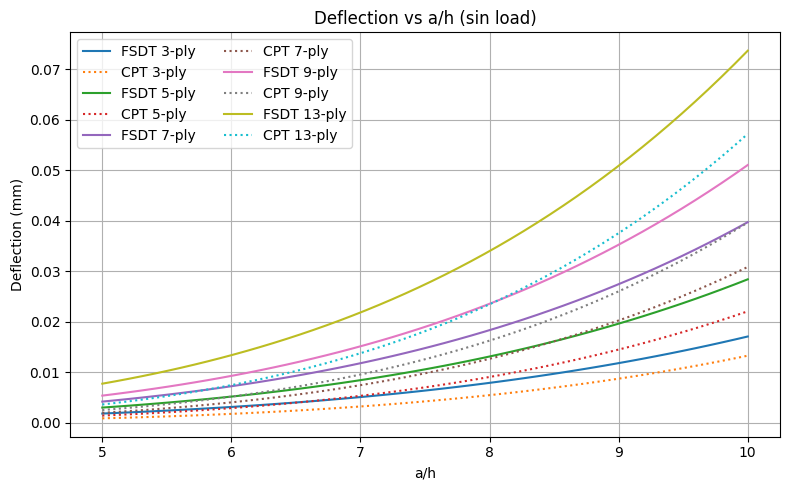

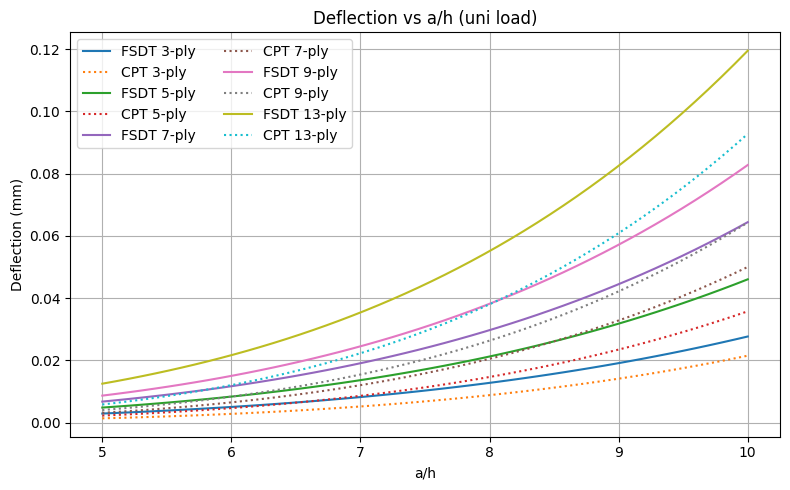

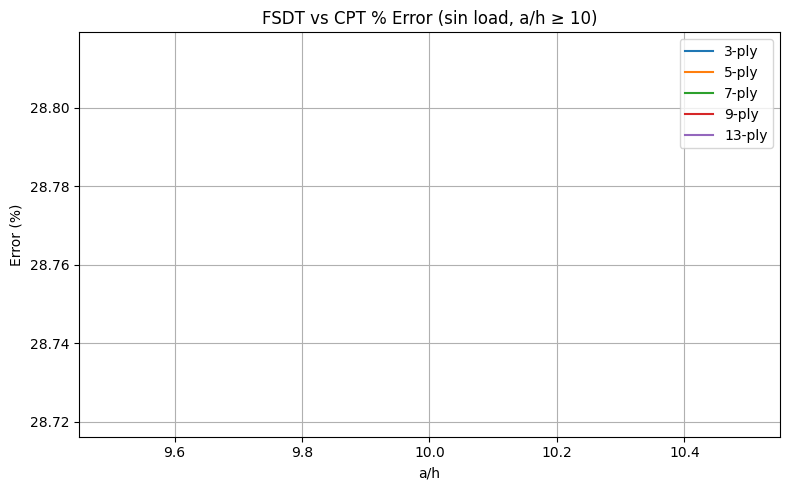

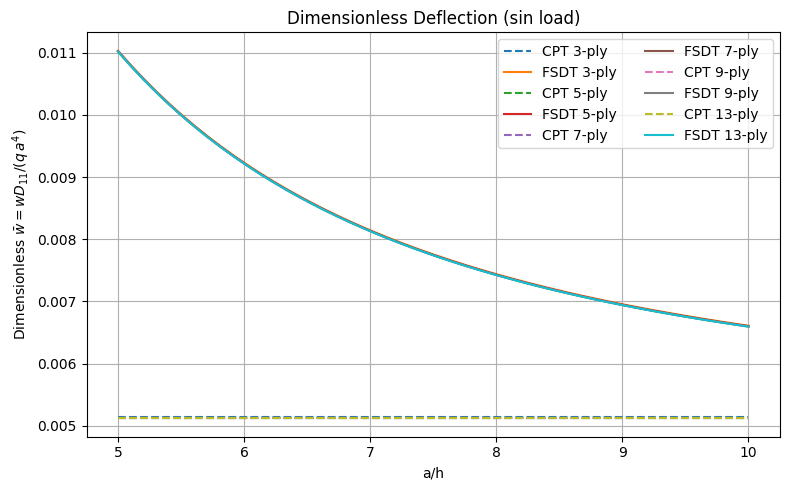

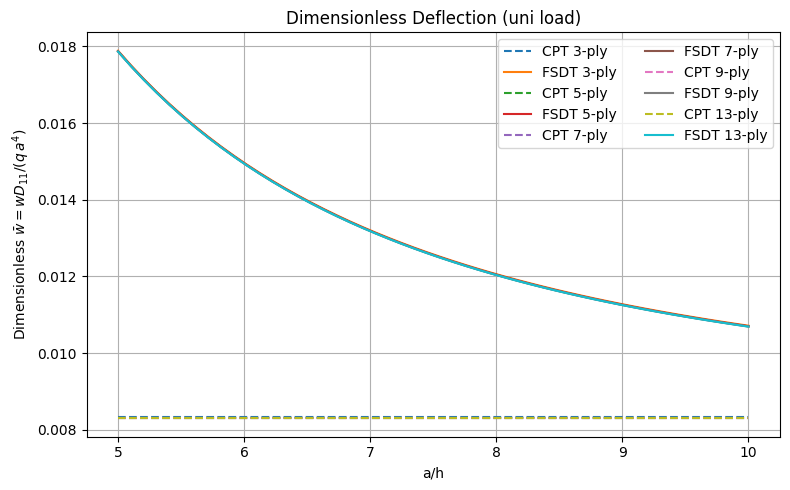

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------- MATERIAL CONSTANTS ----------------------
E_l   = 11_712e6    # Pa (longitudinal modulus)
E_t   =  8_274e6    # Pa (transverse modulus)
nu12  = 0.03        # Poisson’s ratio
G_l   =   732e6     # Pa (shear modulus longitudinal)
G_t   =    73.2e6   # Pa (shear modulus transverse)
q0    = 2.4e3       # N/m²

# ---------------------- Q‐MATRIX FUNCTIONS ----------------------
def Q_local_custom(E1, E2, nu12, G12, G13, G23):
    nu21 = nu12 * E2 / E1
    d    = 1 - nu12 * nu21
    Q11  = E1 / d
    Q12  = nu12 * E2 / d
    Q22  = E2 / d
    return np.array([
        [Q11, Q12,   0,    0,    0],
        [Q12, Q22,   0,    0,    0],
        [  0,   0,  G12,   0,    0],
        [  0,   0,   0,   G23,   0],
        [  0,   0,   0,    0,   G13]
    ])

def transform_Q(Q, θ):
    t = np.radians(θ)
    c,s = np.cos(t), np.sin(t)
    c2,s2 = c*c, s*s
    s2c2 = s2*c2

    Q11,Q12,Q66 = Q[0,0],Q[0,1],Q[2,2]
    Q22         = Q[1,1]
    Q11b = Q11*c2*c2 + 2*(Q12+2*Q66)*s2c2 + Q22*s2*s2
    Q22b = Q11*s2*s2 + 2*(Q12+2*Q66)*s2c2 + Q22*c2*c2
    Q12b = (Q11+Q22-4*Q66)*s2c2 + Q12*(c2*c2 + s2*s2)
    Q66b = (Q11+Q22-2*Q12-2*Q66)*s2c2 + Q66*(c2*c2 + s2*s2)
    Q16b = (Q11-Q12-2*Q66)*c**3*s + (Q12-Q22+2*Q66)*c*s**3
    Q26b = (Q11-Q12-2*Q66)*s**3*c + (Q12-Q22+2*Q66)*s*c**3
    Q44b = Q[3,3]*c2 + Q[4,4]*s2
    Q55b = Q[4,4]*c2 + Q[3,3]*s2
    Q45b = (Q[4,4]-Q[3,3])*s*c

    Qb = np.zeros((5,5))
    Qb[0,0],Qb[0,1],Qb[0,2] = Q11b,Q12b,Q16b
    Qb[1,0],Qb[1,1],Qb[1,2] = Q12b,Q22b,Q26b
    Qb[2,0],Qb[2,1],Qb[2,2] = Q16b,Q26b,Q66b
    Qb[3,3],Qb[4,4]         = Q44b,Q55b
    Qb[3,4],Qb[4,3]         = Q45b,Q45b
    return Qb

# ---------------------- BUILD ABD + As ----------------------
def build_ABD_As_custom(angles, thicknesses):
    A = np.zeros((3,3)); B = np.zeros((3,3)); D = np.zeros((3,3))
    As= np.zeros((2,2))
    # true z‐coordinates (m)
    z = [-sum(thicknesses)/2]
    for t in thicknesses:
        z.append(z[-1]+t)
    for i,θ in enumerate(angles):
        z1,z2 = z[i], z[i+1]
        dz    = z2-z1
        # assign lamina moduli
        if θ==0:
            E1,E2,G12,G13,G23 = E_l,E_t,G_l,G_l,G_t
        else:
            E1,E2,G12,G13,G23 = E_t,E_l,G_l,G_t,G_l
        Q   = Q_local_custom(E1,E2,nu12,G12,G13,G23)
        Qb  = transform_Q(Q,θ)
        A  += Qb[:3,:3] * dz
        B  += 0.5 * Qb[:3,:3] * (z2**2 - z1**2)
        D  += (1/3)* Qb[:3,:3] * (z2**3 - z1**3)
        As +=         Qb[3:5,3:5] * dz
    return A,B,D,As

# ---------------------- DEFLECTION SOLVER ----------------------
j = 5.0/6.0
def deflection_laminate(a_h, load_type, A,B,D,As, use_shear, h):
    a      = a_h * h
    α = β  = np.pi / a
    # membrane + coupling terms
    s11 = A[0,0]*α**2 + A[2,2]*β**2
    s12 = (A[0,1]+A[2,2])*α*β
    s22 = A[2,2]*α**2 + A[1,1]*β**2
    s13 = - (B[0,0]*α**3 + (B[0,1]+2*B[2,2])*α*β**2)
    s23 = - (B[1,1]*β**3 + (B[0,1]+2*B[2,2])*β*α**2)
    k44 =     D[0,0]*α**4 + 2*(D[0,1]+2*D[2,2])*α**2*β**2 + D[1,1]*β**4
    q_eff = q0 if load_type=='sin' else (16/np.pi**2)*q0

    if use_shear:
        s33 = j * (As[1,1]*α**2 + As[0,0]*β**2)
        K = np.array([
            [s11,s12,s13, 0],
            [s12,s22,s23, 0],
            [s13,s23,k44, 0],
            [  0,  0,  0,s33]
        ])
        F = np.array([0,0,q_eff,q_eff])
        sol = np.linalg.solve(K,F)
        w_m = sol[2] + sol[3]
    else:
        # CPT pure‐bending
        K3 = np.array([
            [s11,s12,s13],
            [s12,s22,s23],
            [s13,s23,k44]
        ])
        F3 = np.array([0,0,q_eff])
        sol = np.linalg.solve(K3,F3)
        w_m = sol[2]

    return w_m * 1000  # mm

# ---------------------- CLT LAYUPS ----------------------
clt_data = {
    3:  {'layup':[0,90,0],                't':[0.035]*3},
    5:  {'layup':[0,90,0,90,0],            't':[0.035]*5},
    7:  {'layup':[0,90,0,90,0,90,0],      't':[0.035]*7},
    9:  {'layup':[0,90,0,90,0,90,0,90,0],  't':[0.035]*9},
   13:  {'layup':[0,90]*6 + [0],          't':[0.035]*13}
}

# ---------------------- COMPUTATION ----------------------
ah_range = np.linspace(5,10,50)  # a/h from 3 to 100
deflections = {n:{'FSDT_sin':[],'CPT_sin':[],'FSDT_uni':[],'CPT_uni':[]} for n in clt_data}
errors      = {n:{'sin':[],'uni':[]} for n in clt_data}
EIeff       = {}  # store D11
h_vals      = {}

for n,data in clt_data.items():
    layup,th = data['layup'],data['t']
    h = sum(th); h_vals[n]=h
    A,B,D,As = build_ABD_As_custom(layup,th)
    EIeff[n] = D[0,0]
    for ah in ah_range:
        for lt in ('sin','uni'):
            w_f = deflection_laminate(ah,lt,A,B,D,As, True,  h)
            w_c = deflection_laminate(ah,lt,A,B,D,As, False, h)
            deflections[n][f'FSDT_{lt}'].append(w_f)
            deflections[n][f'CPT_{lt}'].append(w_c)
            errors[n][lt].append(100*(w_f-w_c)/w_c if w_c else np.nan)

# ---------------------- EIeff TABLE ----------------------
print("Ply | tₚ(mm) |    D11 (N·m²/m)")
for n in sorted(EIeff):
    print(f"{n:3d}-ply | {n*35:7d} | {EIeff[n]:12.3e}")

# ---------------------- RAW DEFLECTION PLOTS ----------------------
for lt in ('sin', 'uni'):
    plt.figure(figsize=(8,5))
    for n in sorted(deflections):
        plt.plot(ah_range, deflections[n][f'FSDT_{lt}'], '-', label=f'FSDT {n}-ply')
        plt.plot(ah_range, deflections[n][f'CPT_{lt}'], linestyle='dotted', label=f'CPT {n}-ply')  # <- Dotted line
    plt.xlabel('a/h')
    plt.ylabel('Deflection (mm)')
    plt.title(f'Deflection vs a/h ({lt} load)')
    plt.grid(True)
    plt.legend(ncol=2)
    plt.tight_layout()

# ---------------------- ERROR PLOT (sin load) ----------------------
plt.figure(figsize=(8,5))
for n in sorted(errors):
    ah_f, e_f = zip(*[(ah,e) for ah,e in zip(ah_range,errors[n]['sin']) if ah>=10])
    plt.plot(ah_f, e_f, label=f'{n}-ply')
plt.xlabel('a/h'); plt.ylabel('Error (%)')
plt.title('FSDT vs CPT % Error (sin load, a/h ≥ 10)')
plt.grid(True); plt.legend(); plt.tight_layout()

# ---------------------- DIMENSIONLESS DEFLECTION PLOTS ----------------------
for load in ('sin','uni'):
    plt.figure(figsize=(8,5))
    for n in sorted(deflections):
        w_f_m = np.array(deflections[n][f'FSDT_{load}']) * 1e-3
        w_c_m = np.array(deflections[n][f'CPT_{load}'])  * 1e-3
        a_vals = ah_range * h_vals[n]
        wd_f = w_f_m * EIeff[n] / (q0 * a_vals**4)
        wd_c = w_c_m * EIeff[n] / (q0 * a_vals**4)
        plt.plot(ah_range, wd_c, '--', label=f'CPT {n}-ply')
        plt.plot(ah_range, wd_f,  '-',  label=f'FSDT {n}-ply')
    plt.xlabel('a/h')
    plt.ylabel(r'Dimensionless $\bar w = wD_{11}/(q\,a^4)$')
    plt.title(f'Dimensionless Deflection ({load} load)')
    plt.grid(True); plt.legend(ncol=2); plt.tight_layout()

plt.show()
